In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from pdpbox import info_plots

import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Config

In [2]:
base_dir = "../data/"
data_path = os.path.join(base_dir, "pima_indians_diabetes.csv")

## Load Dataset

In [3]:
data = pd.read_csv(data_path)

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Preprocess Dataset

In [7]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [9]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (614, 8)
y_train: (614,)
X_test: (154, 8)
y_test: (154,)


## Train Model

In [10]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [12]:
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"Train Accuracy (%): {acc_train*100:.2f}")
print(f"Test Accuracy (%): {acc_test*100:.2f}")

Train Accuracy (%): 100.00
Test Accuracy (%): 75.97


## Interpretation

### Tree Visualization

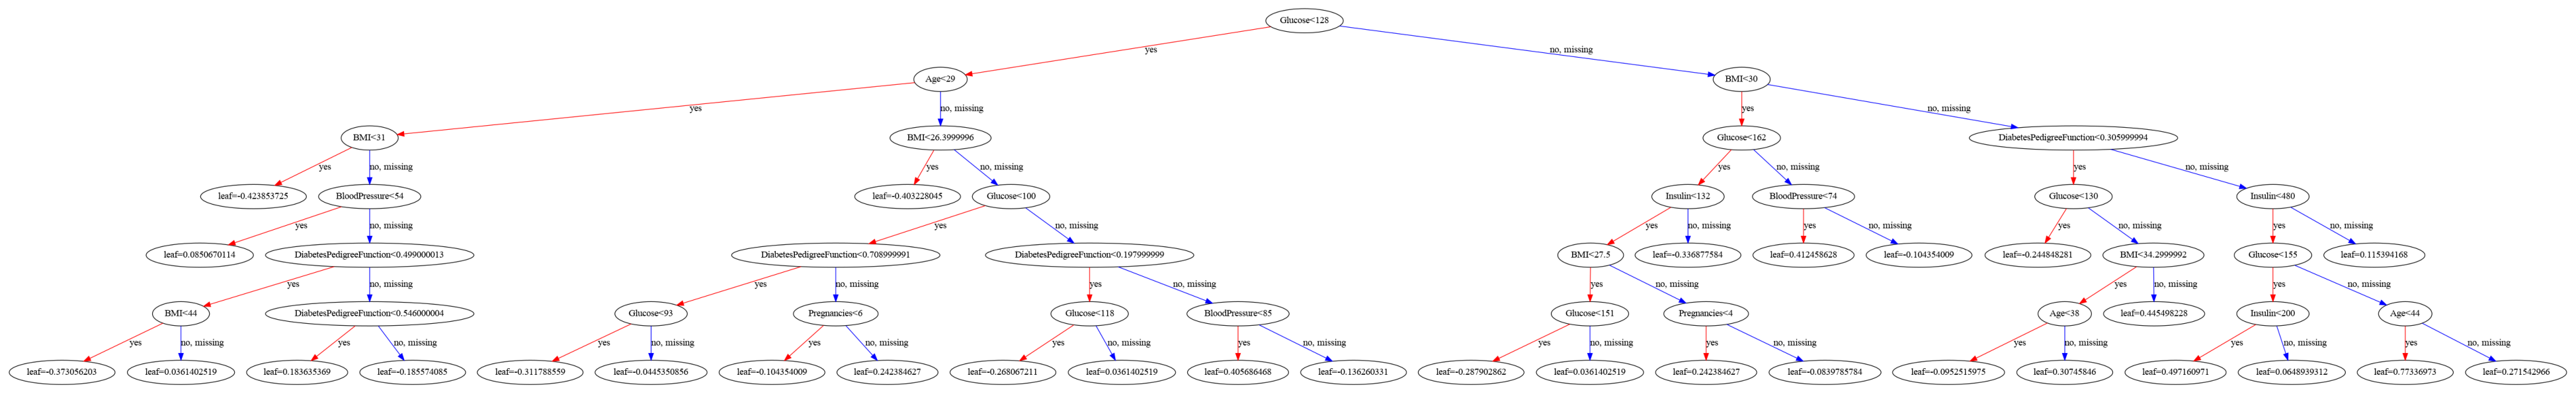

In [13]:
fig, ax = plt.subplots(figsize=(50, 25))
ax = plot_tree(model, ax=ax, num_trees=0)

In [14]:
value = [
    {
        'Pregnancies': 1,
        'Glucose': 161, 
        'BloodPressure': 72,
        'SkinThickness': 35,
        'Insulin': 0,
        'BMI': 28.1,
        'DiabetesPedigreeFunction': 0.527,
        'Age': 20,
    }
]

In [15]:
# Glucose >= 128, BMI < 30, Glucose < 162, Insulin < 132, BMI >= 27.5, Pregnancies < 4
#  logit = 0.242384627
# P(diabetes) = 0.64
# P(no diabetes) = 0.36

model.predict_proba(pd.DataFrame(value))

array([[0.35877454, 0.64122546]], dtype=float32)

In [16]:
# NOTE: this value may differ from model.predict_prob since XGBoost uses ensemble of trees to get a final output

1 / (1+np.exp(-0.242384627))

0.5603012191599062

### Feature Importance
1. estimate the original error $e_{orig} = L(y, \hat{f(X)})$
2. For each feature $j \in {1, ..., p}$ do:
    - Generate feature matrix $X_{perm}$ by permuting feature j in the data X. This breaks the association between feature j and true outcome y.
    - Estimate error $e_{perm}= L(y, \hat{f}(X_{perm})) based on the predictions of the perfumed data.$
    - Calculate permutation feature importance as quotient $FI_j=e_{perm}/e_{orig}$ or difference $FI_{j}=e_{perm}-e{orig}$
3. Sort features by descending FI

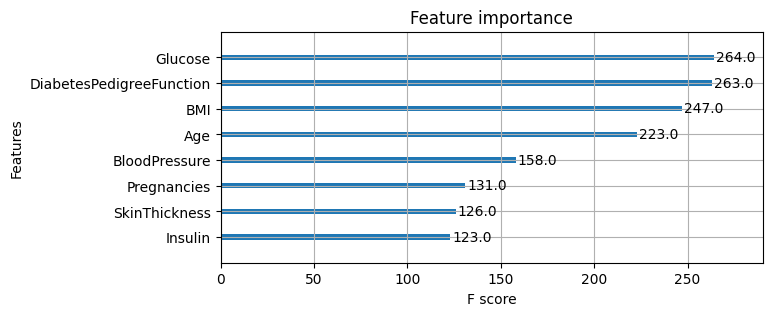

In [17]:
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_importance(model, ax=ax)

### Partial Dependence Plot (PDP)

In [18]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
feature_cols = data.columns[:-1].tolist()
target_col = data.columns[-1]

In [20]:
tmp = info_plots.TargetPlot(
    df=data,
    feature="Glucose",
    feature_name="Glucose",
    target=target_col
)

/usr/local/lib/python3.8/dist-packages/pdpbox/utils.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x"] = cut_result.codes
/usr/local/lib/python3.8/dist-packages/pdpbox/utils.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x"] = df.apply(


In [21]:
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.sans-serif'] = ['DejaVu Sans']

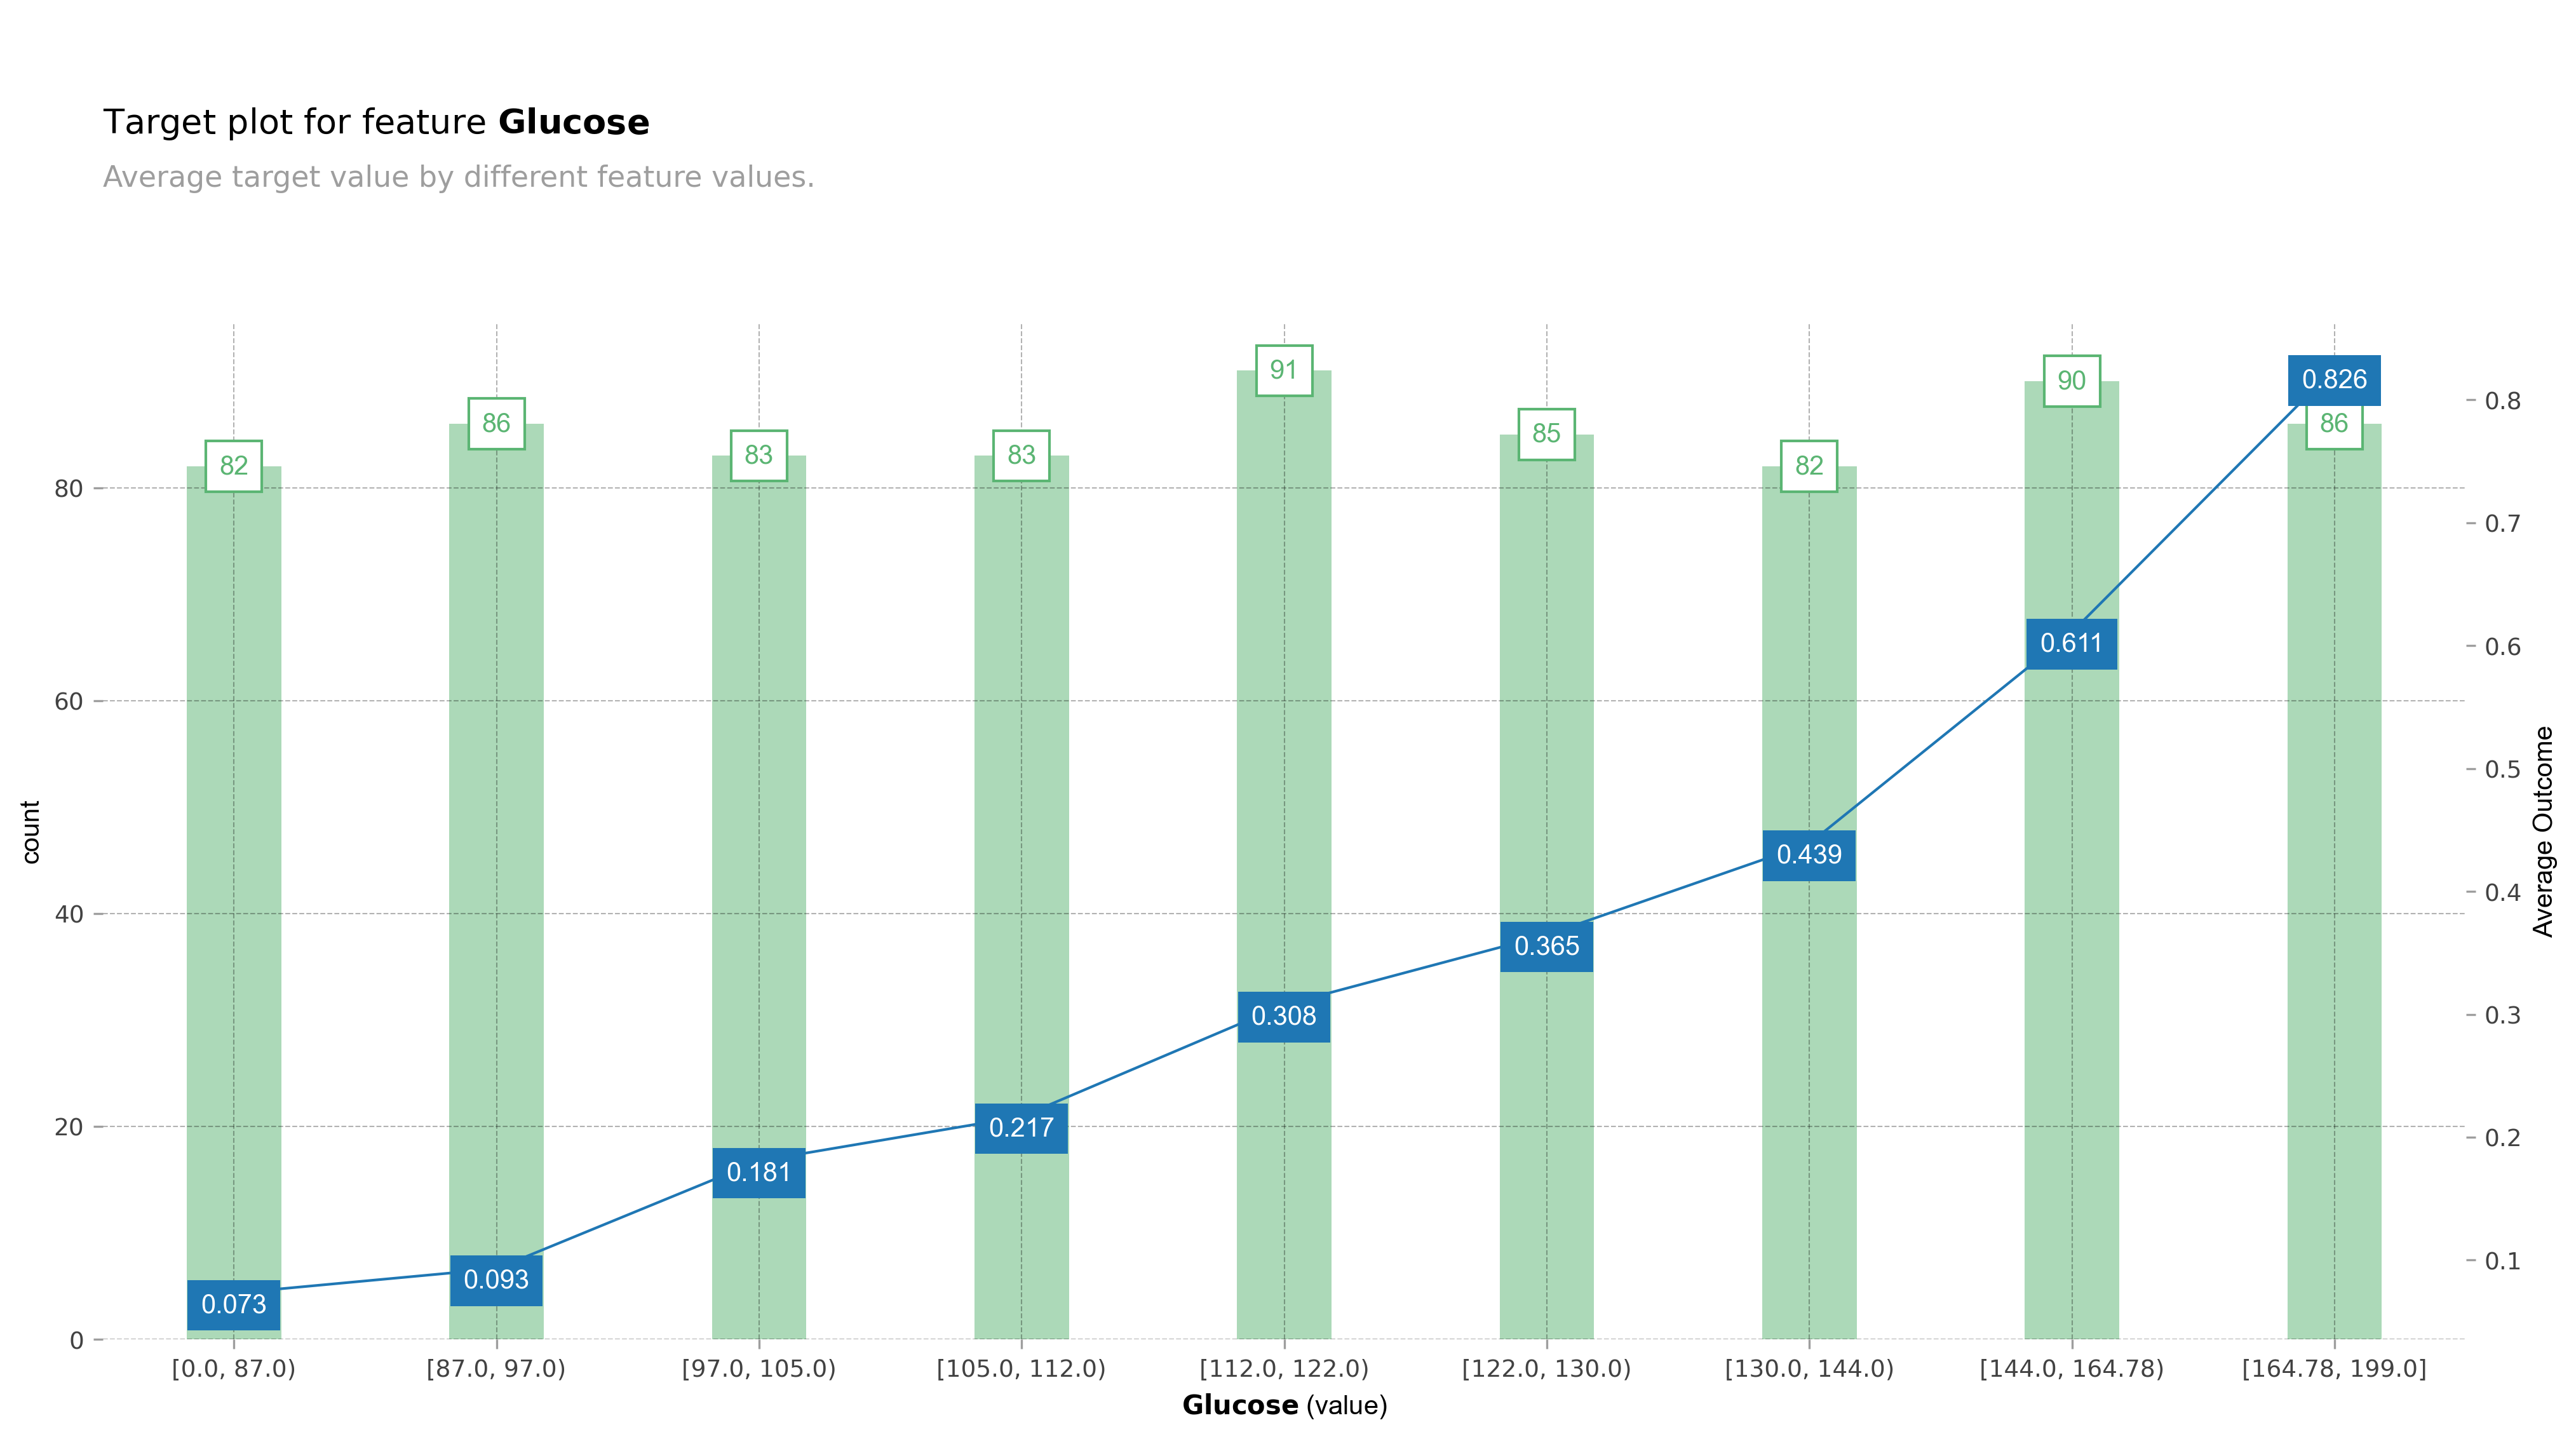

In [22]:
fig, axes, summary_df = tmp.plot(engine="matplotlib")